# Stock Market Prediction - JP Morgan Bank

## Importing required libraries

In [ ]:
#Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

#Metrics
import datetime as dt
import os
import math, time
import itertools
from operator import itemgetter
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable

#Arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import statsmodels.api as sm

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

## Describing the data

This project focuses on assessing stock market price predictions. The prevalence of volatility in the stock market 
makes predicting stock prices anything but simple (Ullah et al, 2022). Financial professionals often face the challenge of obtaining accurate price predictions. In this project we will explore various machine learning techniques to predict the price performance of JP Morgan Bank, and explore whether unique investment opportunities exist. Human judgement cannot always identify patterns in huge datasets, and predictions are often prevalent to individual bias and emotions.  

Due to confidentiality and data governance sensitivities of using workplace data, I have exported data from Yahoo Finance which covers the period 2006 - 2017. Features of this dataset include the Open, High, Low and Close prices of the JPM stock. It also covers the Volume of trades.

In [2]:
df = pd.read_csv("JPM_stock_prediction.csv", index_col='Date', parse_dates=["Date"])
df.shape

(3020, 6)

There are 3020 rows and 6 columns in the dataset.

In [3]:
df.head(5)

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.83,40.36,39.30,40.19,12839400,JPM
2006-01-04,39.78,40.14,39.42,39.62,13491800,JPM
2006-01-05,39.61,39.81,39.50,39.74,8109400,JPM
2006-01-06,39.92,40.24,39.55,40.02,7966900,JPM
2006-01-09,39.88,40.72,39.88,40.67,16575200,JPM


In [4]:
df.tail(5)

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,108.20,108.46,106.80,107.45,14573385,JPM
2017-12-26,107.20,107.99,106.40,107.02,7403739,JPM
2017-12-27,106.67,107.29,106.67,107.22,9496548,JPM
2017-12-28,107.40,107.84,107.16,107.79,7440555,JPM
2017-12-29,108.09,108.28,106.94,106.94,8925701,JPM


We will ensure our dataset is free from error by removing null values. 

In [5]:
print ("\nMissing values :  ", df.isnull().sum().values.sum())
print ("\nUnique values :  \n", df.nunique())


Missing values :   2

Unique values :  
 Open      2153
High      2142
Low       2151
Close     2175
Volume    3020
Name         1
dtype: int64


In [6]:
df.dropna(inplace=True)
df.isna().any()

Open      False
High      False
Low       False
Close     False
Volume    False
Name      False
dtype: bool

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


## Exploratory analysis

We will explore elements of our dataset through visual analysis.

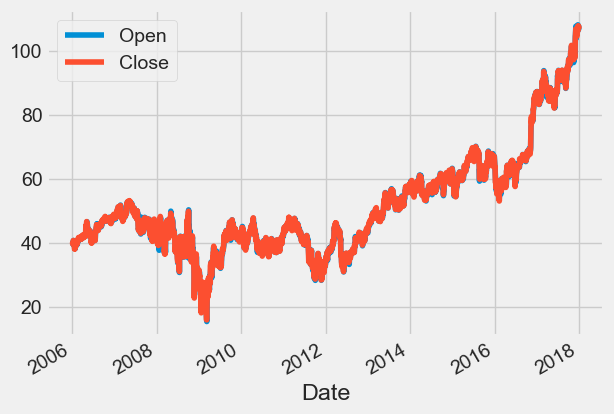

In [8]:
df[['Open','Close']].plot()
plt.show()

We can see from the plot above that the open and close prices follow similar trends, and there are not any major discrepencies. 

We will create a new dataframe to assess the Closing price of the JPM index, which represents the closing price for shares at the end of that day. This new dataframe ensures no irrelavant variables take part in our forecasting. 

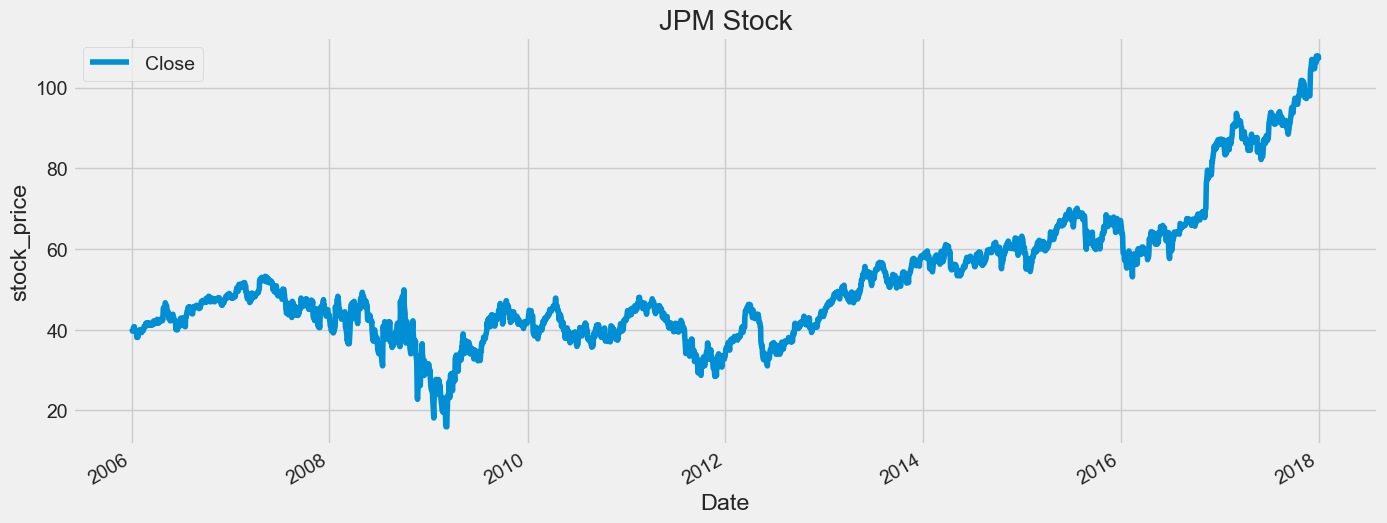

In [9]:
df_jpm = df[['Close']]
df_jpm.plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("JPM Stock")
plt.show()

## Long short-term memory (LSTM)

We will use LSTM to predict the stock price of JPM. LSTM is a useful RNN technique that is capable of learning long-term dependencies (Olah, 2015). This model is a good fit as it works with time series data over long periods of time to accurately predict stock prices. We will normalise the dataset so it follows a common scale. MinMaxScaler will be used to scale the data features in range [0,1] or [-1,1] as we anticipate there will be negative price ranges in the dataset. Our model will be built using PyTorch.

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
df_jpm['Close'] = sc.fit_transform(df_jpm['Close'].values.reshape(-1,1))

C:\Users\329707\AppData\Local\Temp\ipykernel_24436\2689441831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jpm['Close'] = sc.fit_transform(df_jpm['Close'].values.reshape(-1,1))


The training set is 80% and the test set is 20% of the total dataset. We will define a look-back period of 20 sequences. 

In [11]:
def load_data(stock, lookback):
    data_raw = stock.to_numpy() 
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    X_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    X_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [X_train, y_train, X_test, y_test]
lookback = 20 
X_train, y_train, X_test, y_test = load_data(df_jpm, lookback)

In [12]:
print('x_train.shape = ',X_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',X_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


In [13]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [14]:
y_train.size(),X_train.size()

(torch.Size([2399, 1]), torch.Size([2399, 19, 1]))

We will now build the structure of the model. We will define the hyperparameter such as epochs, hidden size, input size, output size, hidden state and number of layers. As we are building our model in PyTorch, we will use the nn.Module superclass to define the class of each layer.  

In [15]:
input_dim = 1 #input gate (adds information to the cell state)
hidden_dim = 32 #hidden state
num_layers = 2 #number of layers
output_dim = 1 #output size (selects information to be shown as output)

In this stage we complete the Forward Pass and apply backpropagation. 

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

We will now instantiate the LSTM model, and define the loss function and optimiser.

In [17]:
lstm_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss = torch.nn.MSELoss()

optimiser = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
print(lstm_model)
print(len(list(lstm_model.parameters())))
for i in range(len(list(lstm_model.parameters()))):
    print(list(lstm_model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


We now train the model, this involves looping for the number of epochs, completing the forward pass, obtaining the loss function and adjusting the weights through the optimiser. We start training for 100 epochs and print the loss at every 10 epochs. 

In [18]:
num_epochs = 100
hist = np.zeros(num_epochs)

seq_dim =lookback-1  

for t in range(num_epochs):
    y_train_pred = lstm_model(X_train)

    loss_function = loss(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss_function.item())
    hist[t] = loss_function.item()
    optimiser.zero_grad()
    loss_function.backward()
    optimiser.step()

Epoch  10 MSE:  0.012622909620404243
Epoch  20 MSE:  0.009586922824382782
Epoch  30 MSE:  0.008497850969433784
Epoch  40 MSE:  0.0012987711234018207
Epoch  50 MSE:  0.0011181969894096255
Epoch  60 MSE:  0.0005756915779784322
Epoch  70 MSE:  0.0004772479587700218
Epoch  80 MSE:  0.0004307323833927512
Epoch  90 MSE:  0.00037759481347166


From the results, we can see there is a reduction of loss at every 10 epochs. We will now visualise this loss:

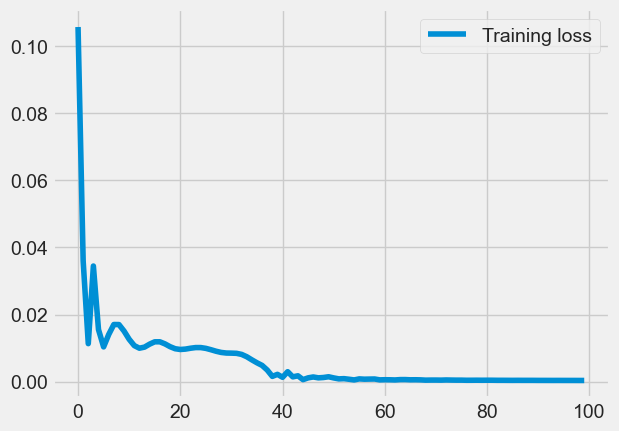

In [19]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

We can see training loss decreases as the number of epochs increase. 

We will now perform predictions on the whole dataset and transform it into the right format.

In [20]:
y_test_pred = lstm_model(X_test)

y_train_pred = sc.inverse_transform(y_train_pred.detach().numpy())
y_train = sc.inverse_transform(y_train.detach().numpy())
y_test_pred = sc.inverse_transform(y_test_pred.detach().numpy())
y_test = sc.inverse_transform(y_test.detach().numpy())

We will use evaluation metrics: Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) to measure the error of the LSTM model. 

In [21]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.74 RMSE
Test Score: 10.35 RMSE


In [22]:
# calculate mean squared error
trainScore1 = mean_squared_error(y_train[:,0], y_train_pred[:,0])
testScore1 = mean_squared_error(y_test[:,0], y_test_pred[:,0])
print('Train Score: %.2f MSE' % (trainScore1))
print('Test Score: %.2f MSE' % (testScore1))

Train Score: 3.02 MSE
Test Score: 107.08 MSE


In [23]:
# calculate mean squared error
trainScore2 = mean_absolute_error(y_train[:,0], y_train_pred[:,0])
testScore2 = mean_absolute_error(y_test[:,0], y_test_pred[:,0])
print('Train Score: %.2f MAE' % (trainScore2))
print('Test Score: %.2f MAE' % (testScore2))

Train Score: 1.28 MAE
Test Score: 7.43 MAE


In the LSTM model, we obtained a higher value for RMSE, MSE and MAE, which indicates that error and bias within the model has undermined the predicted results.

We will now visualise the test prediction and assess how well the model is performing:

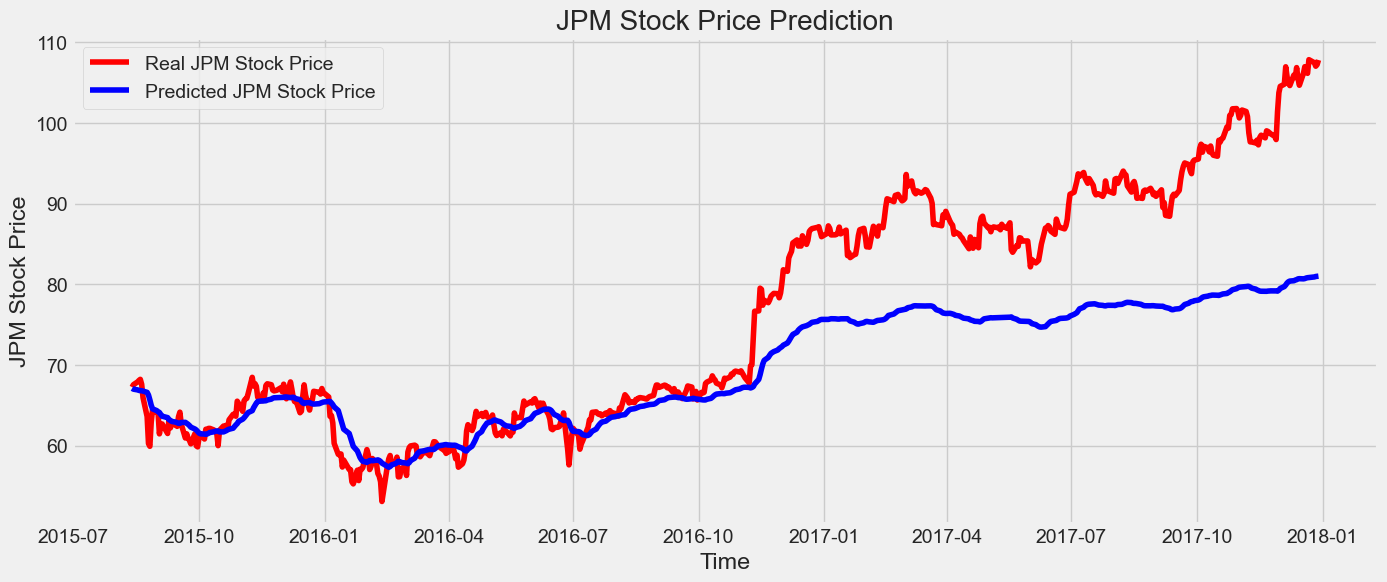

In [24]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_jpm[len(df_jpm)-len(y_test):].index, y_test, color = 'red', label = 'Real JPM Stock Price')
axes.plot(df_jpm[len(df_jpm)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted JPM Stock Price')

plt.title('JPM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('JPM Stock Price')
plt.legend()
plt.savefig('jpm_pred.png')
plt.show()

The LSTM model has produced some promising results, it predicted a steady positive increase in the stock price of JPM, however it underperformed compared to the actual stock price. 

## Autoregressive integrated moving average (ARIMA)

Firstly, we will conduct a stationary test by looking at the Partial Autocorrelation and Autocorrelation functions. 

In [25]:
df_jpm = df[['Close']]

C:\Miniconda3\envs\lime\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


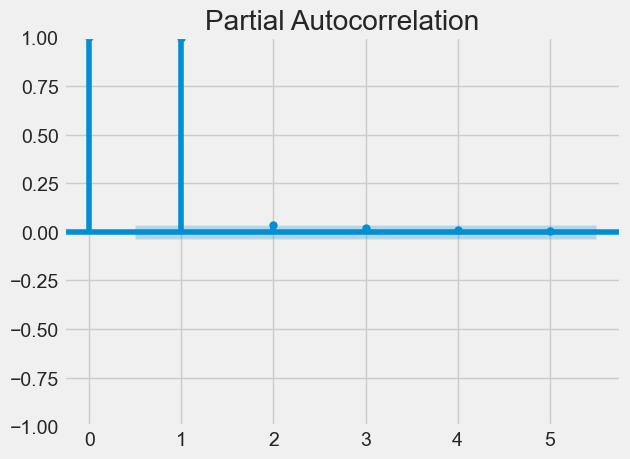

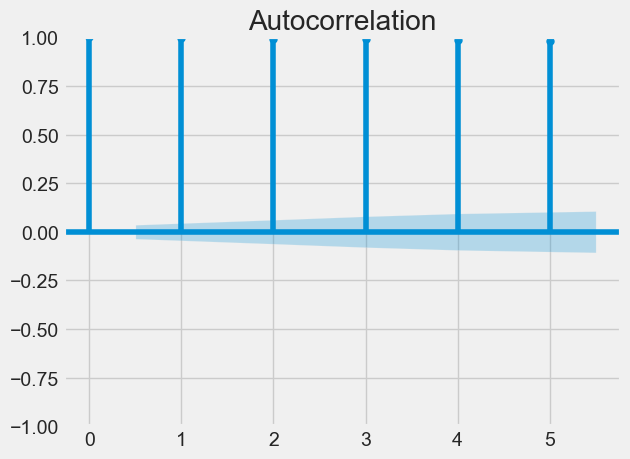

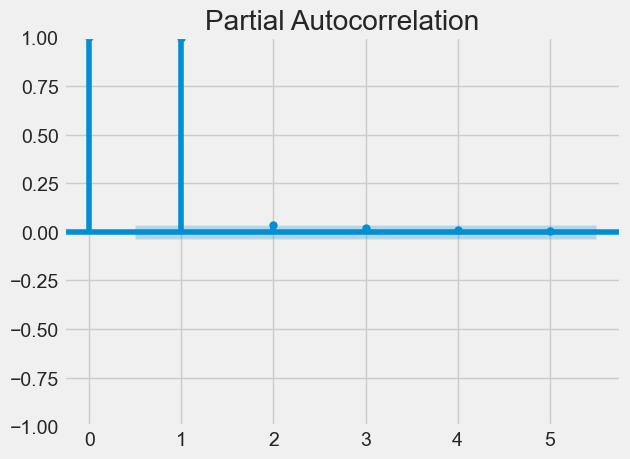

In [26]:
plot_acf(df_jpm, lags=5)
plot_pacf(df_jpm, lags=5)

We can see from PACF that lag 1 and 2 are significant. From ACF all 5 lags are significant. 

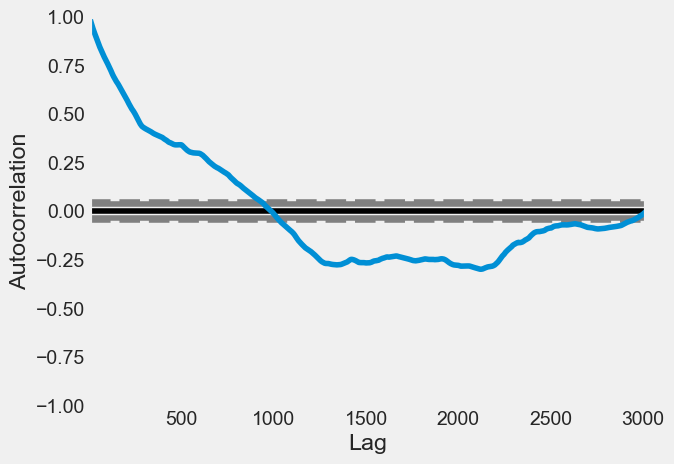

<Figure size 800x560 with 0 Axes>

In [27]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_jpm)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

We will use the Augmented Dickey Fuller (ADF) test to detect stationarity in our dataset. Our hypothesis is as follows:

Ho: the time series is non-stationary

H1: the time series is stationary
    
    If the p-value is less than the significance level of 0.05 we reject our null hypothesis. 

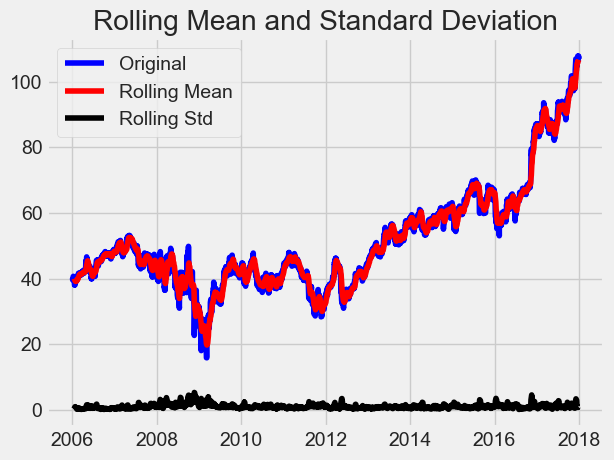

Results of dickey fuller test
Test Statistics                   1.111263
p-value                           0.995312
No. of lags used                 29.000000
Number of observations used    2989.000000
critical value (1%)              -3.432540
critical value (5%)              -2.862507
critical value (10%)             -2.567285
dtype: float64


In [28]:
#Test for staionarity
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')

    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_jpm)

The p-value of 0.995 is above 0.05 which means we accept our null hypothesis that our data is non-stationary. To perform time series analysis, we will decompose time series data into trend and seasonality. 

<Figure size 640x480 with 0 Axes>

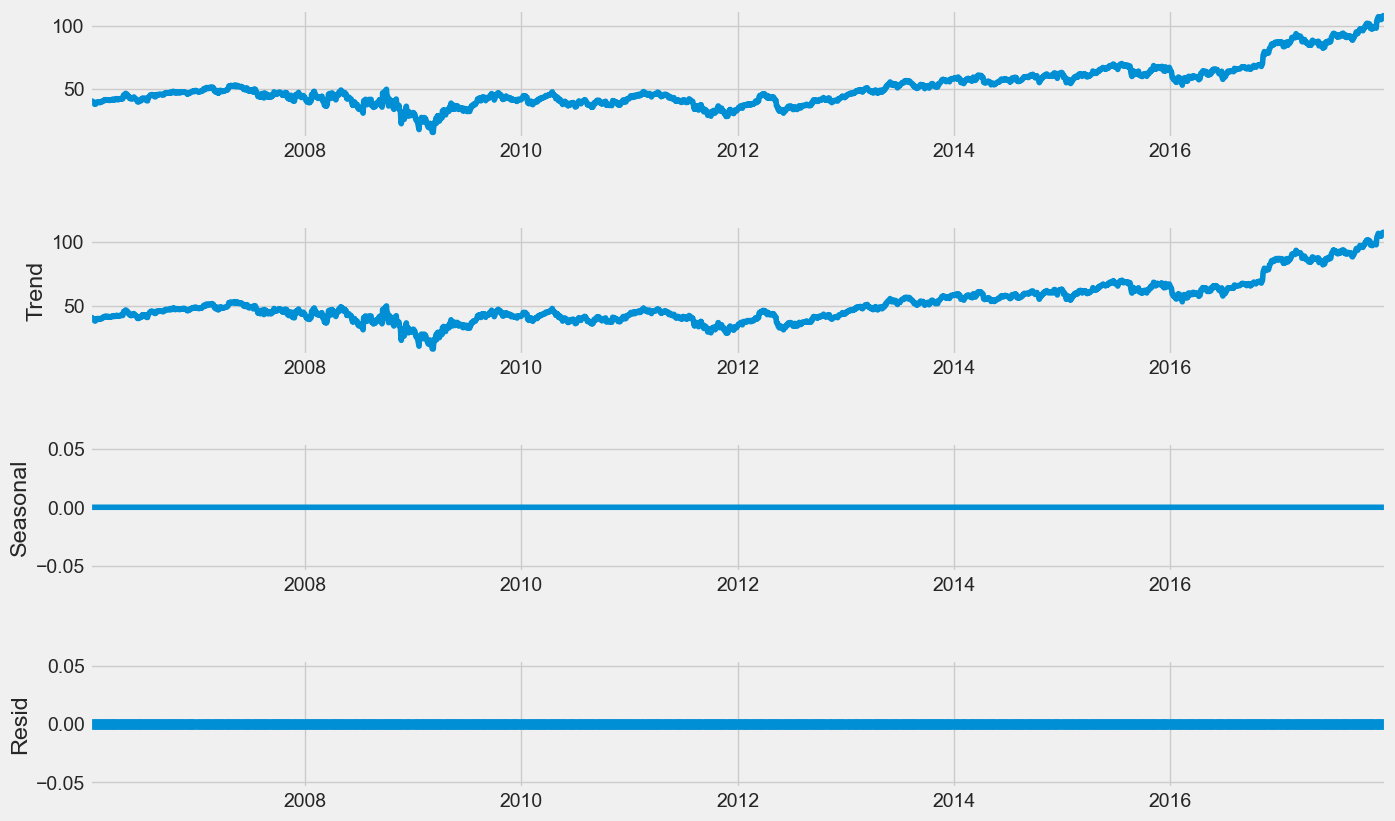

In [29]:
# We will decompose the series to separate the trend and seasonality from the time series. 
result = seasonal_decompose(df_jpm, model='additive', period=1)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


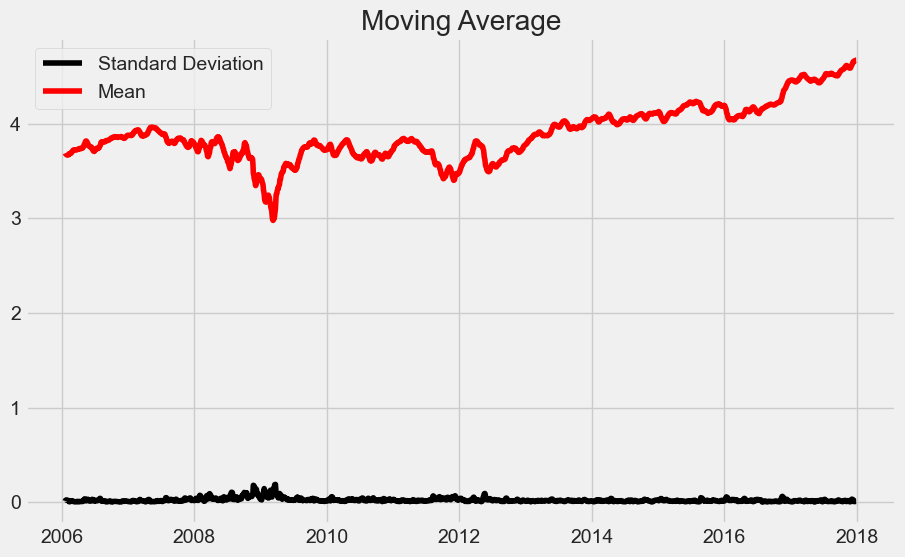

In [30]:
#We will eliminate the non-stationary trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_jpm)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [31]:
X, y = df_log[0:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
training_data = X.values
testing_data = y.values

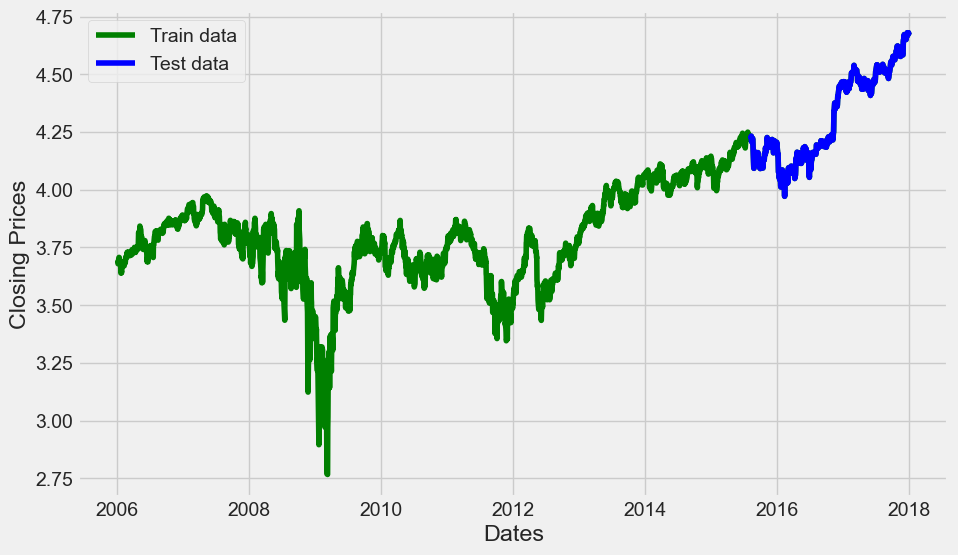

In [32]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(y, 'blue', label='Test data')
plt.legend()

We will now build our ARIMA model and identify the right parameters. 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10445.488, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10469.062, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10470.927, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10447.337, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10476.709, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10485.757, Time=1.61 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10469.890, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-10472.366, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10473.437, Time=1.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10482.427, Time=1.66 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-10473.810, Time=0.59 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-10483.019, Time=2.38 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-10487.947, Time=0.72 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10487.962, Time=0.47 sec
 ARIM

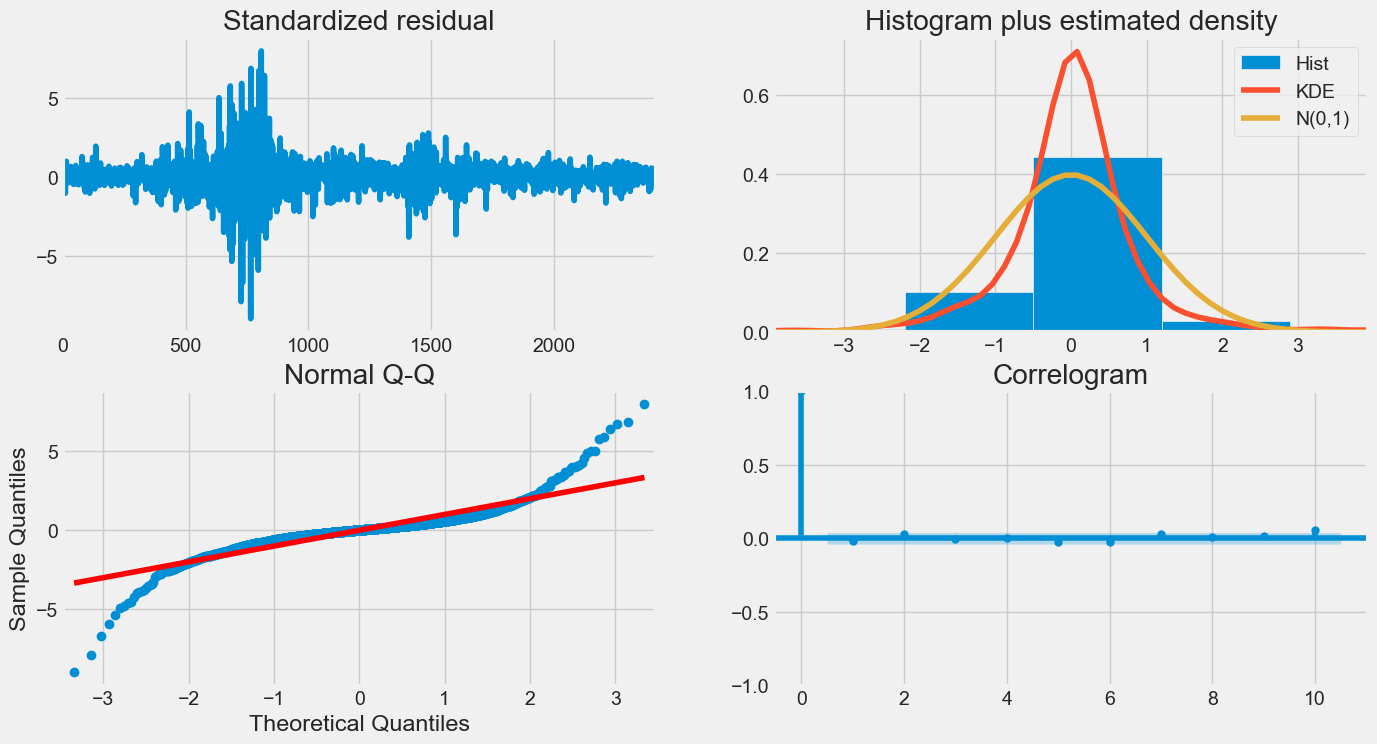

In [33]:
model_autoARIMA = auto_arima(X, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,          
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

The plot diagnostics above infer the following:
- Standard redisual: the residual errors fluctuate around zero and have a uniform variance. 
- Histogram plus estimated density: the histogram plot infers a normal distribution with mean of zero.
- Normal Q-Q: Towards the centre, the red line is aligned with the dots however the edges deviate from the line which could imply skewness exists in the distribution. 
- Correlogram: The residual errors are not autcorrelated. Autocorrelation would imply the residual errors have an unexplainable pattern. 

The optimum model for forecasting indicates ARIMA(1,1,1)(0,0,0)[0] is the best model. 

In [34]:
history = [x for x in training_data]
predictions = list()
for t in range(len(testing_data)):
    model = ARIMA(history, order=(1,1,1))  
    fitted = model.fit()  
    output = fitted.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = testing_data[t]
    history.append(obs)

In [35]:
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))

MSE: 0.00019374987277366048


In [36]:
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))

MAE: 0.009597959246531167


In [37]:
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

RMSE: 0.013919406336969278


Compared to LSTM, we obtained a lower value from RMSE, MSE and MAE, which indicates the results under ARIMA were more accurate. We will now visualise the predicted results: 

C:\Users\329707\AppData\Local\Temp\ipykernel_24436\3758080168.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "green" (-> color=(0.0, 0.5019607843137255, 0.0, 1.0)). The keyword argument will take precedence.
  plt.plot(df_log,'green', color='blue', label='Training Data')


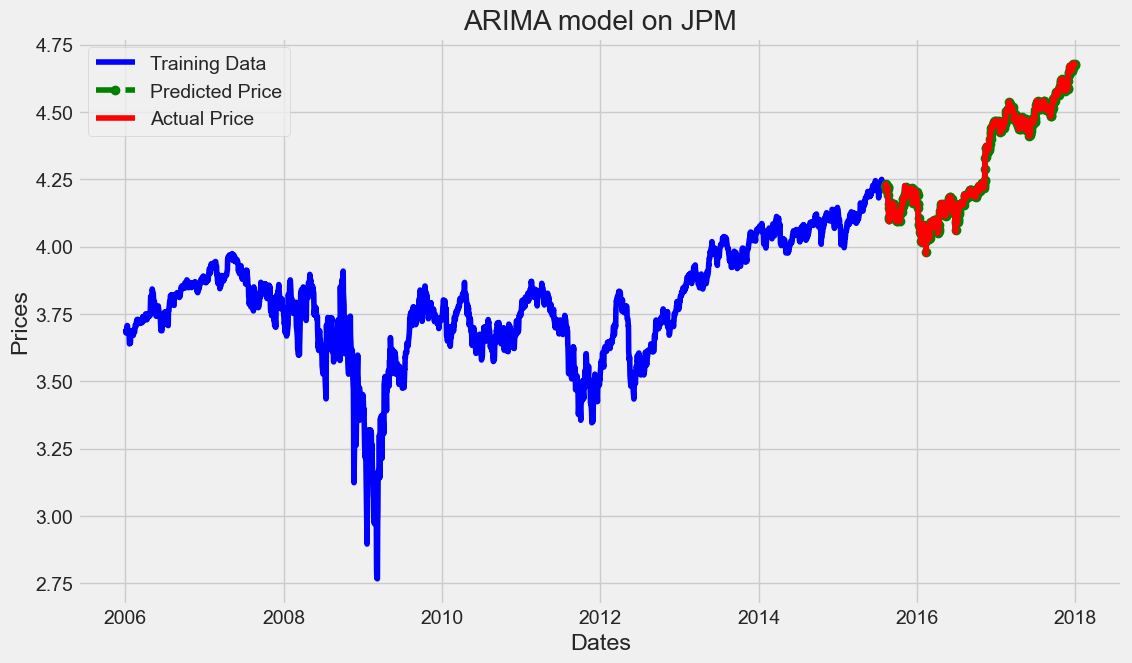

In [38]:
plt.figure(figsize=(12,7))
plt.plot(df_log,'green', color='blue', label='Training Data')
plt.plot(y.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(y.index, y, color='red', label='Actual Price')
plt.title('ARIMA model on JPM')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

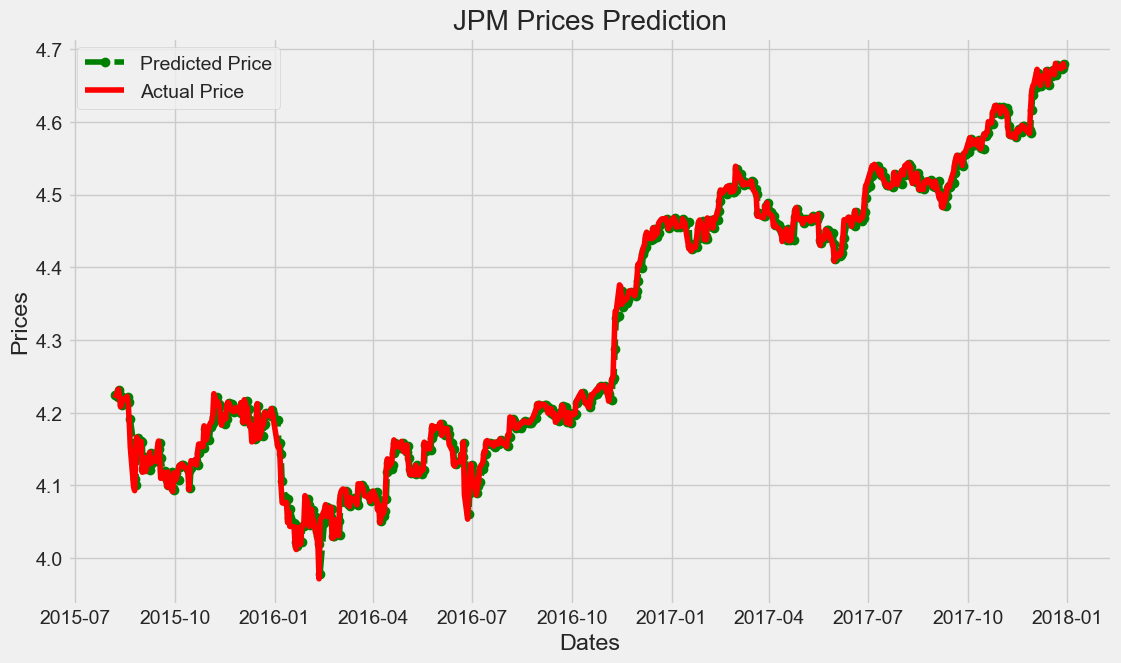

In [39]:
plt.figure(figsize=(12,7))
plt.plot(y.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(y.index, y, color='red', label='Actual Price')
plt.title('JPM Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

Our model seems to have performed well. The visualisation shows an accurate prediction and the accuracy metrics indicates high accuracy of the model due to the lower value obtained for RMSE, MSE and MAE. 

## Conclusion

Overall, we can conclude that the ARIMA model performs better than the LSTM model. This is because the data has been normalised, which means the ARIMA model better explained the time-series based on historical linear data with simple temporal dependencies. The LSTM model was a better fit for time-series data with long-term dependencies. Although, we have found these models are not entirely accurate with predicting stock prices as accuracy metrics show elements of error, therefore, the financial professionals may still want to consider an element of human judgement when making important financial decisions.  

## References

Olah, C. (2015) Understanding LSTM networks, Understanding LSTM Networks -- colah's blog. Available at: https://colah.github.io/posts/2015-08-Understanding-LSTMs/ (Accessed: January 16, 2023). 

Ullah, A.K.M.A. et al. (2022) Combining machine learning and effective feature selection for real-time stock trading in variable time-frames, arXiv.org. Available at: https://arxiv.org/abs/2107.13148 (Accessed: October 21, 2022). 
